In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

TFRecord

In [2]:
with tf.io.TFRecordWriter('my_data.tfrecord') as f:
    f.write(b'This is the first record')
    f.write(b'And this is the second record')

In [3]:
filepaths = ['my_data.tfrecord']
dataset = tf.data.TFRecordDataset(filepaths)

for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


In [4]:
filepaths = ['my_test_{}.tfrecord'.format(i) for i in range(5)]

for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write('File {} record {}'.format(i, j).encode('utf-8'))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)

for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [5]:
options = tf.io.TFRecordOptions(compression_type='GZIP')

with tf.io.TFRecordWriter('my_compressed.tfrecord', options) as f:
    f.write(b'This is the first record')
    f.write(b'And this is the second record')
    
dataset = tf.data.TFRecordDataset(['my_compressed.tfrecord'], 
                                  compression_type='GZIP')

for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


Protocol Buffers

In [6]:
%%writefile person.proto
syntax = 'proto3';
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


In [7]:
!protoc --version

libprotoc 3.17.3


In [8]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [9]:
from person_pb2 import Person

person = Person(name='AI', id=123, email=['a@b.com'])
print(person)

name: "AI"
id: 123
email: "a@b.com"



In [10]:
person.name

'AI'

In [11]:
person.name = 'Alice'
person.name

'Alice'

In [12]:
person.email

['a@b.com']

In [13]:
person.email.append('c@d.com')
person.email

['a@b.com', 'c@d.com']

In [14]:
person.email[0]

'a@b.com'

In [15]:
s = person.SerializeToString()
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [16]:
person2 = Person()
person2.ParseFromString(s)

27

In [17]:
person == person2

True

Custom protobuf

In [18]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type='Person',
    field_names=['name', 'id', 'email'],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source='person.desc'
)

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

TensorFlow Protocol Buffers

In [19]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            'name': Feature(bytes_list=BytesList(value=[b'Alice'])),
            'id': Feature(int64_list=Int64List(value=[123])),
            'emails': Feature(bytes_list=BytesList(value=[b'a@b.com', b'c@d.com'])),
        }))

with tf.io.TFRecordWriter('my_contacts.tfrecord') as f:
    f.write(person_example.SerializeToString())

In [20]:
feature_description = {
    'name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'emails': tf.io.VarLenFeature(tf.string),
}

for serialized_example in tf.data.TFRecordDataset(['my_contacts.tfrecord']):
    parsed_example = tf.io.parse_single_example(serialized_example, 
                                                feature_description)

In [21]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1e6534b36c8>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [22]:
parsed_example['emails']

In [23]:
parsed_example['emails'].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [24]:
tf.sparse.to_dense(parsed_example['emails'], default_value=b'')

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [25]:
parsed_example['emails'].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

Putting images in TFRecords

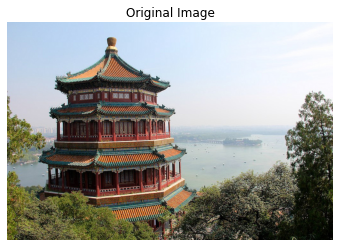

In [26]:
from sklearn.datasets import load_sample_images

img = load_sample_images()['images'][0]

plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

In [27]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    'image': Feature(bytes_list=BytesList(value=[data.numpy()]))
}))
serialized_example = example_with_image.SerializeToString()

In [28]:
feature_description = {'image': tf.io.VarLenFeature(tf.string)}
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image['image'].values[0])

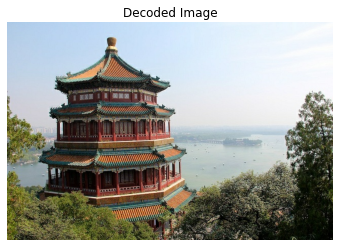

In [29]:
decoded_img = tf.io.decode_image(example_with_image['image'].values[0])

plt.imshow(decoded_img)
plt.axis('off')
plt.title('Decoded Image')
plt.show()

Putting Tensors and Sparse Tensors in TFRecords

In [30]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [31]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [32]:
serialized_sparse = tf.io.serialize_sparse(parsed_example['emails'])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [33]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [34]:
dataset = tf.data.TFRecordDataset(['my_contacts.tfrecord']).batch(10)

for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_example, 
                                         feature_description)

In [35]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1e652d4abc8>}

SequenceExample

In [36]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    'author_id': Feature(int64_list=Int64List(value=[123])),
    'title': Feature(bytes_list=BytesList(value=[b'A', b'desert', b'place', b'.'])),
    'pub_date': Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

In [37]:
def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode('utf-8') 
                                               for word in words]))

In [38]:
content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]

sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        'content': FeatureList(feature=content_features),
        'comments': FeatureList(feature=comments_features),
    }))

In [39]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [40]:
serialized_sequence_example = sequence_example.SerializeToString()

In [41]:
context_feature_descriptions = {
    'author_id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'title': tf.io.VarLenFeature(tf.string),
    'pub_date': tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}

sequence_feature_descriptions = {
    'content': tf.io.VarLenFeature(tf.string),
    'comments': tf.io.VarLenFeature(tf.string),
}

parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, 
    context_feature_descriptions, 
    sequence_feature_descriptions)

In [42]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1e65b778408>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [43]:
parsed_context['title'].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [44]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1e65b778448>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1e65b778488>}

In [45]:
tf.RaggedTensor.from_sparse(parsed_feature_lists['content'])

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>